# Drug Discovery for Dengue Virus NS-3 Helicase

## Primary Authors:
- Clarissa Harmoko
- Kai Ze Tam
- Kyle Carlo Lasala
- Muhammad Abdul Aziz Ghazali

## Prepare Libraries

In [1]:
!pip install biopython
!pip install ipywidgets==7.7.2
!pip install rdkit
!pip install qiskit==1.4.3
!pip install qiskit-nature
!conda install nglview -c conda-forge -y
!conda install -c conda-forge MDAnalysis -y

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.3.0
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 516.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.0/611.0 kB 779.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 3.0 MB/s eta 0:00:0000:0100:01


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 3.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 3.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.5/759.5 kB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.8/839.8 kB 3.4 MB/s eta 0:00:00ta 0:00:01
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95/95 [ipywidgets]5 [notebook]b]ver]zer]xers]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 25.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [rdkit]32m1/2 [rdkit]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 10.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 3.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 32.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [qiskit]2m7/8 [qiskit]kx]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 12.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [qiskit-nature]0m [qiskit-nature]hms]


In [2]:
# node needed! 
# installs the js packages for nglview
!npm i

In [8]:
# will only run in linux
!pip install --prefer-binary pyscf

In [1]:
import os
import ipywidgets as widgets 
from Bio.PDB import PDBList, PDBParser
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import nglview as nv
import numpy as np
from docking_py import docking

/home/kyle/miniforge3/envs/docking/lib/python3.13/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.settings import settings

## Prepare Dataset

### Download the target protein
- The target is the NS3 RNA helicase (a viral protein/enzyme) of Dengue virus serotype 2 (DENV2). This helicase unwinds double-stranded RNA (dsRNA) intermediates into single-stranded RNA (ssRNA), a critical step in the replication of the viral genome.

In [3]:
pdb_id = "2BMF"
pdbl = PDBList()

In [4]:
if not os.path.exists("data"):
    os.mkdir("data")
file_path = pdbl.retrieve_pdb_file(pdb_id, file_format="pdb", pdir="./data/")
file_name = "data/DENV2_RNA_Helicase_2_4A.pdb"
if os.path.exists(file_name):
    os.remove(file_name)
os.rename(file_path, file_name)

In [5]:
parser = PDBParser(QUIET=True)
structure = parser.get_structure(pdb_id, file_name)
view = nv.show_biopython(structure)
view

NGLWidget()

### Select a particular ligand
- The ligand selected is based on the study of Halim et al. [1]. The ligand with the highest Chemgauss2 (CG2) score is selected. The Simplified Molecular Input Line Entry System (SMILES) format of the selected ligand is `CCOc1ccc2c(c1)sc(n2)NC(=O)c3c(cnc(n3)SC)Br`. This will be used to benchmark the tools.

[1] S. A. Halim, S. Khan, A. Khan, A. Wadood, F. Mabood, J. Hussain, and A. Al-Harrasi, “Targeting Dengue Virus NS-3 Helicase by Ligand based Pharmacophore Modeling and Structure based Virtual Screening,” Frontiers in Chemistry, vol. 5, p. 88, 2017. [Online]. Available: https://doi.org/10.3389/fchem.2017.00088

In [6]:
# ligand = "CCOc1ccc2c(c1)sc(n2)NC(=O)c3c(cnc(n3)SC)Br"
ligand = "CC1=C(C2=C(C=C1)N=C(S2)C3=CC4=C(C=C3)N=C(S4)C5=CC=C(C=C5)NC(=O)C6=CC7=C(C=C6)N=C(S7)C8=CC=C(C=C8)N)S(=O)(=O)[O-].[NH4+]"

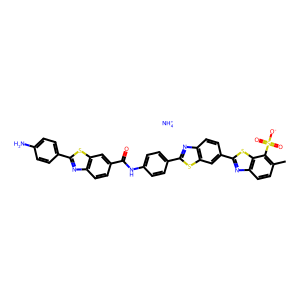

In [7]:
mol = Chem.MolFromSmiles(ligand)
Draw.MolToImage(mol)

Save this into pdb format

In [8]:
mol_wHs = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol_wHs)
AllChem.UFFOptimizeMolecule(mol_wHs)
ligand_file = "data/ligand.pdb"
Chem.MolToPDBFile(mol_wHs, ligand_file)

Compute the center of the compound

In [9]:
symbols = []
coords = []
ligand_chain_id = 'A'
for model in structure:
    for chain in model:
        if chain.id == ligand_chain_id:
            for residue in chain:
                for atom in residue:
                    symbol = atom.element  # element symbol
                    coord = atom.coord     # numpy array of (x, y, z)
                    symbols.append(symbol)
                    coords.append(coord)
symbols = np.array(symbols).reshape(-1,1)
coords = np.array(coords)
atoms = np.hstack([symbols, coords])
centroid = np.array(coords).mean(axis=0)

Select the part of the ligand within the radius from the center

In [10]:
radius = 4
selected = np.linalg.norm(centroid - coords, axis=1) <= radius
if not any(selected): raise Exception("No selected atoms. Increase the radius.")
selected_atoms = atoms[selected]
print(f"{len(selected_atoms)} atoms are selected.")

10 atoms are selected.


In [11]:
str_atoms = ''
for each in selected_atoms:
    str_atoms += ' '.join(each) + '; '
str_atoms

'C 7.673 1.233 56.963; C 6.837 0.765 57.967; C 7.106 1.585 55.732; C 5.457 0.649 57.757; C 5.731 1.474 55.513; C 4.905 1.006 56.527; C 6.137 -2.333 54.88; C 4.757 -2.16 55.487; O 4.646 -2.261 56.731; O 3.785 -1.928 54.728; '

## Molecular Docking

In [12]:
test_dock = docking.Docking('test', lig_pdb='data/ligand.pdb', rec_pdb='data/DENV2_RNA_Helicase_2_4A.pdb')
test_dock.prepare_ligand()

python2.7 ../../../../../../../../home/kyle/miniforge3/envs/docking/bin/prepare_ligand4.py -l ligand.pdb -B none -A hydrogens -o ligand.pdbqt


In [13]:
test_dock.prepare_receptor()

python2.7 ../../../../../../../home/kyle/miniforge3/envs/docking/bin/prepare_receptor4.py -r data/DENV2_RNA_Helicase_2_4A.pdb -A checkhydrogens -o data/DENV2_RNA_Helicase_2_4A.pdbqt


In [14]:
test_dock.run_docking(out_pdb='data/output_dock.pdb',
                      num_modes=10,
                      energy_range=10,
                      exhaustiveness=5,
                      dock_bin='smina')

Grid points: None


smina --ligand data/ligand.pdbqt --receptor data/DENV2_RNA_Helicase_2_4A.pdbqt --log data/output_dock_log.txt --num_modes 10 --exhaustiveness 5 --energy_range 10 --out data/output_dock.pdb --size_x 112.00 --size_y 139.00 --size_z 133.00 --center_x -2.68 --center_y 23.88 --center_z 39.77


In [15]:
rmsd_list = test_dock.compute_dock_rmsd(test_dock.lig_pdbqt)

File name doesn't finish with .pdb read it as .pdb anyway


In [16]:
rmsd_list

[np.float64(63.25280166662949),
 np.float64(62.48875116696428),
 np.float64(60.18796906992885),
 np.float64(62.57296083339534),
 np.float64(60.64761371987569),
 np.float64(73.03881856338856),
 np.float64(64.26406170346782),
 np.float64(60.20899009495374),
 np.float64(63.90912761896339),
 np.float64(72.9690844739476)]

In [17]:
view_dock = test_dock.view_dock(ref_pdb="data/DENV2_RNA_Helicase_2_4A.pdb")
view_dock

NGLWidget(max_frame=9)

### Classical Computation Benchmark

### Quantum Computation Benchmark

In [55]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper

driver = PySCFDriver(atom=str_atoms, basis="sto3g")
problem = driver.run()

# Reduce problem size
transformer = ActiveSpaceTransformer(
    num_electrons=2,
    num_spatial_orbitals=2
)
problem = transformer.transform(problem)

mapper = JordanWignerMapper()

second_q_op = problem.second_q_ops()[0]
qubit_op = mapper.map(second_q_op)
# qubit_op = mapper.map(problem.hamiltonian)

In [56]:
qubit_op

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'YYII', 'YYIZ', 'XXII', 'XXIZ', 'ZIII', 'ZIIZ', 'IIYY', 'IZYY', 'IIXX', 'IZXX', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.61514706+0.j,  0.03117762+0.j,  0.0554125 +0.j,  0.06316887+0.j,
  0.03117762+0.j,  0.0772238 +0.j,  0.00783969+0.j,  0.00112066+0.j,
  0.00783969+0.j,  0.00112066+0.j,  0.0554125 +0.j,  0.07418501+0.j,
  0.00783969+0.j,  0.00112066+0.j,  0.00783969+0.j,  0.00112066+0.j,
  0.01101614+0.j,  0.01101614+0.j,  0.01101614+0.j,  0.01101614+0.j,
 -0.00684096+0.j, -0.00684096+0.j,  0.07418501+0.j, -0.00684096+0.j,
 -0.00684096+0.j,  0.09003528+0.j,  0.06316887+0.j])